In [1]:
## This file produces data for the model to use

import os
import json
from dotenv import load_dotenv
import torch
import time
import math, random
from pymongo import MongoClient
from bson.objectid import ObjectId
from pymongo.server_api import ServerApi
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


## Load Config
with open('config/videos.json') as config_file:
    videos = json.load(config_file)
with open('config/name_to_url.json') as config_file:
    name_to_url = json.load(config_file)
with open('config/alltopics.json') as config_file:
    alltopics = json.load(config_file)
with open('config/indexedtopics.json') as config_file:
    json_output = json.load(config_file)
    topic_subtopic = {}
    for topic_obj in json_output:
        topic_subtopic[topic_obj["topic"]] = topic_obj["subtopics"]

load_dotenv(dotenv_path=".env")


True

In [2]:
from pinecone import Pinecone

CUR_DIR = os.getcwd()
pc = Pinecone(api_key=os.environ["PINECONE_KEY"])
index = pc.Index("pretechnigala")
DB_NAME = "preTechnigalaClean_db"
COLLECTION_NAME = "video_metadata"
MONGO_DB_CLIENT = MongoClient(os.getenv("MONGODB_URI"), server_api=ServerApi('1'))
OUTPUT_DIR = f"{CUR_DIR}/data/validation"
QUERY_MODE = "avg"  
VECTOR_MODE = "avg"
PATH_TO_EMBEDDINGS = f"{OUTPUT_DIR}/embeddings/{QUERY_MODE}"
PATH_TO_DB_VECTORS = "/Users/klinalb/Workspaces/dartmouth/CS98/discite/rec_engine/inference/pipeline/data/outputs"


/Users/klinalb/anaconda3/envs/CS98/lib/python3.10/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
#### PERFORMS QUERIES BASED ON JUST THE VIDEO EMBEDDINGS
with open(f'{OUTPUT_DIR}/video_query/{VECTOR_MODE}-v_{QUERY_MODE}-q.yaml', 'w') as f:
    for embedding_file in os.listdir(PATH_TO_EMBEDDINGS):
        if not embedding_file.endswith('.pt'):
            continue
        name = embedding_file[4:-3]
        query = torch.load(f'{PATH_TO_EMBEDDINGS}/{embedding_file}', map_location=torch.device('cpu')).tolist()
        response = index.query(vector=query, top_k=5, include_values=True, include_metadata=True, filter={"mode": f"{VECTOR_MODE}_pool"})
        
        f.write(f'Querying {name}:\n')
        for i, obj in enumerate(response["matches"]):
            youtubeURL = "None"
            doc = MONGO_DB_CLIENT[DB_NAME][COLLECTION_NAME].find_one({"_id": ObjectId(obj["metadata"]["videoID"])})
            if doc:
                youtubeURL = doc["youtubeURL"]
            f.write(f'    Rank: {i+1}, Distance: {obj["score"]}\n')
            f.write(f'        Title: {obj["metadata"]["title"]}, URL: {youtubeURL}\n')
            f.write(f'        Topics: {[alltopics[topic] for topic in obj["metadata"]["topics"]]}\n')
            f.write(f'        infTopics: {obj["metadata"]["inferenceTopics"]} \n')
            f.write(f'        infComplexities: {obj["metadata"]["inferenceComplexities"]}\n')

In [3]:
## History Query TESTS
## attempt 3. Checking just two videos, and the distance between them. 

ATTEMPT = 4
HISTORY_LENGTH = 2
TOP_K = 15
QUERIES = 10
SINK = torch.load(f'{PATH_TO_DB_VECTORS}/65d8fc3f95f306b28d1b88fe/{VECTOR_MODE}_pool.pt', map_location=torch.device('cpu'))

os.makedirs(f'{OUTPUT_DIR}/history_query/{VECTOR_MODE}-v_{QUERY_MODE}-q', exist_ok=True)
all_vectors = [] #NAME, VECTOR
for embedding_file in os.listdir(PATH_TO_EMBEDDINGS):
    if not embedding_file.endswith('.pt'):
        continue
    all_vectors.append((embedding_file[4:-3], torch.load(f'{PATH_TO_EMBEDDINGS}/{embedding_file}', map_location=torch.device('cpu'))))

## Randomly make a "watch history" by taking the average of 5 random videos
with open(f'{OUTPUT_DIR}/history_query/{VECTOR_MODE}-v_{QUERY_MODE}-q/{ATTEMPT}.yaml', 'w') as f:
    f.write(f'Parameters: Attempt {ATTEMPT}, History Length {HISTORY_LENGTH}, Top K {TOP_K}, Query Mode {QUERY_MODE}, Vector Mode {VECTOR_MODE}\n\n')
    for run in range(QUERIES):
        f.write(f'\n###################### Run {run+1} #######################\n\n')
        history = random.sample(all_vectors, HISTORY_LENGTH)
        ## Query is the average pool of the history vectors
        query = torch.mean(torch.stack([vec for name, vec in history]), dim=0).numpy().tolist()

        f.write(f'Distance Between History 0,1: {torch.dist(history[0][1], history[1][1])}\n')
        f.write(f'Distance from sink video to 0, 1, and query: {torch.dist(SINK, history[0][1])}, {torch.dist(SINK, history[1][1])}, {torch.dist(SINK, torch.tensor(query))}\n\n')

        response = index.query(vector=query, top_k=15, include_values=True, include_metadata=True, filter={"mode": f"{VECTOR_MODE}_pool"})
        f.write(f'Querying History {run}. Videos: {[name for name, vec in history]}\n')
        for i, obj in enumerate(response["matches"]):
            youtubeURL = "None"
            doc = MONGO_DB_CLIENT[DB_NAME][COLLECTION_NAME].find_one({"_id": ObjectId(obj["metadata"]["videoID"])})
            if doc:
                youtubeURL = doc["youtubeURL"]
            f.write(f'    Rank: {i+1}, Distance: {obj["score"]}\n')
            f.write(f'        Title: {obj["metadata"]["title"]}, URL: {youtubeURL}, ID: {obj["metadata"]["videoID"]}\n')
            f.write(f'        Topics: {[alltopics[topic] for topic in obj["metadata"]["topics"]]}\n')
            f.write(f'        infTopics: {obj["metadata"]["inferenceTopics"]} \n')
            f.write(f'        infComplexities: {obj["metadata"]["inferenceComplexities"]}\n')
        print(f"Run {run+1} of {QUERIES} complete")
    

Run 1 of 10 complete
Run 2 of 10 complete
Run 3 of 10 complete
Run 4 of 10 complete
Run 5 of 10 complete
Run 6 of 10 complete
Run 7 of 10 complete
Run 8 of 10 complete
Run 9 of 10 complete
Run 10 of 10 complete


In [ ]:
###### TOPIC TEST
ATTEMPT = 0
os.makedirs(f'{OUTPUT_DIR}/topic_query/{VECTOR_MODE}-v_{QUERY_MODE}-q', exist_ok=True)
with open(f'{OUTPUT_DIR}/topic_query/{VECTOR_MODE}-v_{QUERY_MODE}-q/{0}.yaml', 'w') as f:
    for topic in alltopics:
            query = torch.load(f'{CUR_DIR}/data/topics/{topic}.pt', map_location=torch.device('cpu')).tolist()
            response = index.query(vector=query, top_k=5, include_values=True, include_metadata=True, filter={"mode": f"{VECTOR_MODE}_pool"})
            f.write(f'Querying {topic}. Topic Name: {alltopics[topic]}\n')
            for i, obj in enumerate(response["matches"]):
                youtubeURL = "None"
                doc = MONGO_DB_CLIENT[DB_NAME][COLLECTION_NAME].find_one({"_id": ObjectId(obj["metadata"]["videoID"])})
                if doc:
                    youtubeURL = doc["youtubeURL"]
                f.write(f'    Rank: {i+1}, Distance: {obj["score"]}\n')
                f.write(f'        Title: {obj["metadata"]["title"]}, URL: {youtubeURL}\n')
                f.write(f'        Topics: {[alltopics[topic] for topic in obj["metadata"]["topics"]]}\n')
                f.write(f'        infTopics: {obj["metadata"]["inferenceTopics"]} \n')
                f.write(f'        infComplexities: {obj["metadata"]["inferenceComplexities"]}\n')

In [74]:
## Load all vectors to map from ID to vector
def load_all_vectors(mode="avg"):
    all_vectors = {}
    # if isvectorized is true
    docs = MONGO_DB_CLIENT[DB_NAME][COLLECTION_NAME].find({"isVectorized": True})
    for doc in docs:
        all_vectors[str(doc["_id"])] = {"vector": torch.load(f'{PATH_TO_DB_VECTORS}/{doc["_id"]}/{mode}_pool.pt', map_location=torch.device('cpu')), "topics": doc["topicId"], "inferenceTopics": doc["inferenceTopics"], "inferenceComplexities": doc["inferenceComplexities"]}
    
    return all_vectors

vectors = load_all_vectors(VECTOR_MODE)


In [105]:
# https://distill.pub/2016/misread-tsne/
tsne_vectors = numpy.array([obj["vector"].numpy() for obj in vectors.values()])
tsne_labels = [set(obj["topics"]) for obj in vectors.values()]

# Use t-SNE to reduce dimensionality
perplexity = 30  
learning_rate = 500
n_iter = 1000

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tsne_vectors)


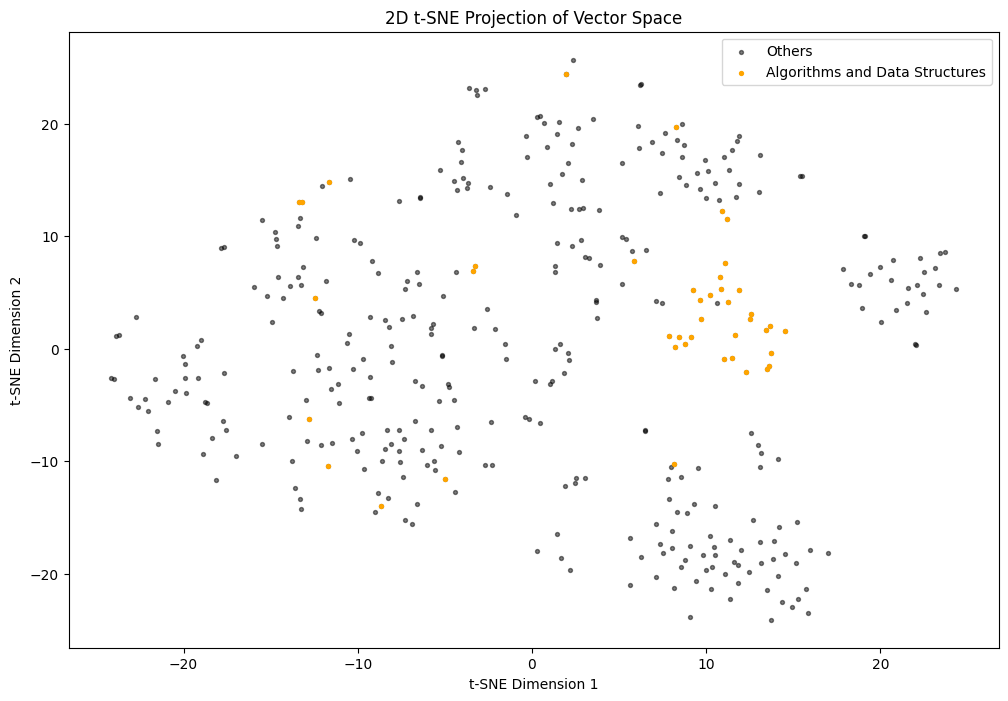

In [106]:
########## SINGLE GRAPH
## A list of torch tensors 
# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot for all vectors
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=8, c='black', alpha=0.5, label='Others')

# Highlight vectors labeled with 
target_topic = 1
target_topic_name = alltopics[str(target_topic)]
highlight_idx = [i for i, label in enumerate(tsne_labels) if target_topic in label]
plt.scatter(tsne_results[highlight_idx, 0], tsne_results[highlight_idx, 1], s=8, c='orange', label=target_topic_name)

plt.title('2D t-SNE Projection of Vector Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()



In [104]:
########## CREATES ALL GRAPHS PER TOPIC HIGHLIGHTED, WRITES TO FILE
## Create a 72 plots and highlight each topic from 1 to 72 in each
os.makedirs(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/single', exist_ok=True)
for target_topic in range(1, 73):
    target_topic_name = alltopics[str(target_topic)]
    highlight_idx = [i for i, label in enumerate(tsne_labels) if target_topic in label]
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=6, c='black', alpha=0.5, label='Others')
    plt.scatter(tsne_results[highlight_idx, 0], tsne_results[highlight_idx, 1], s=14, c='orange', label=target_topic_name)
    plt.title(f'2D t-SNE Projection of Vector Space: {target_topic_name}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    if target_topic_name == "HTML/CSS":
        plt.savefig(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/single/{target_topic}_HTML_CSS.png')
    else:
        plt.savefig(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/single/{"*" if str(target_topic) in topic_subtopic else ""}{target_topic}_{target_topic_name}.png')
    plt.close()



dict_keys(['1', '7', '13', '67', '25', '19', '31'])


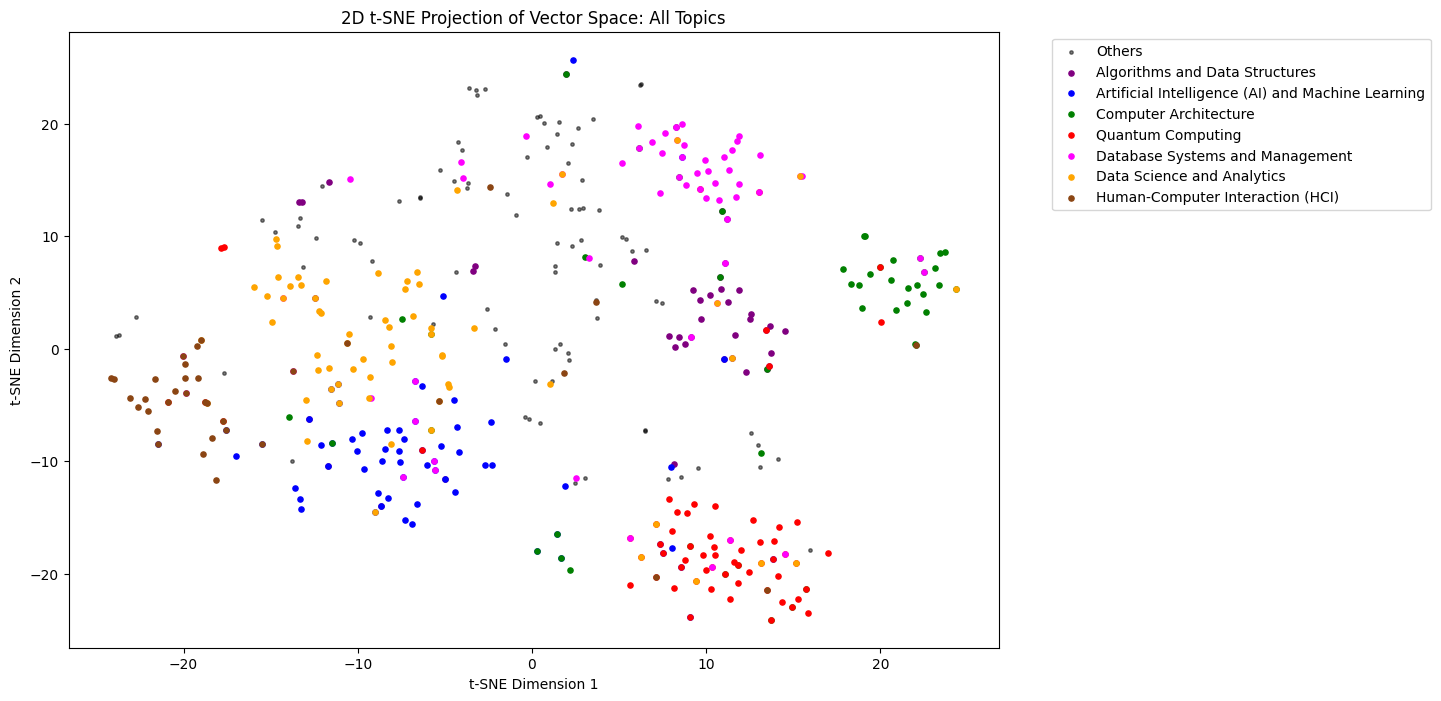

In [100]:
os.makedirs(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/combined/2D', exist_ok=True)
run = len(os.listdir(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/combined/2D')) + 1
f_metadata = open(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/combined/2D/{run}_metadata.yaml', 'w')
f_metadata.write(f'Perplexity: {perplexity}, Learning Rate: {learning_rate}, Iterations: {n_iter}\n')
f_metadata.close()
topic_highlight_idx = {}
topics = [1, 7, 13, 67, 25, 19, 31]
for topic_id in topics:
    highlight_idx = [i for i, label in enumerate(tsne_labels) if int(topic_id) in label]
    topic_highlight_idx[str(topic_id)] = highlight_idx

print(topic_highlight_idx.keys())
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=6, c='black', alpha=0.5, label='Others')
colors = ['purple', 'blue', 'green', 'red', 'magenta', 'orange', 'saddlebrown', 'gray', 'silver', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'brown', 'teal', 'navy', 'maroon', 'lime', 'indigo', 'gold', 'violet', 'turquoise', 'tan', 'silver', 'orchid', 'plum', 'peru', 'palegreen', 'palevioletred', 'papayawhip', 'peachpuff', 'powderblue', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'skyblue', 'slateblue', 'slategray', 'slategrey', 'snow', 'springgreen', 'steelblue', 'tan', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'whitesmoke', 'yellowgreen']
for topic_id in topics:
    highlight_idx = topic_highlight_idx[str(topic_id)]
    plt.scatter(tsne_results[highlight_idx, 0], tsne_results[highlight_idx, 1], s=14, label=alltopics[str(topic_id)], c=colors.pop(0))
plt.title(f'2D t-SNE Projection of Vector Space: All Topics')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/combined/2D/{run}_all_topics.png')


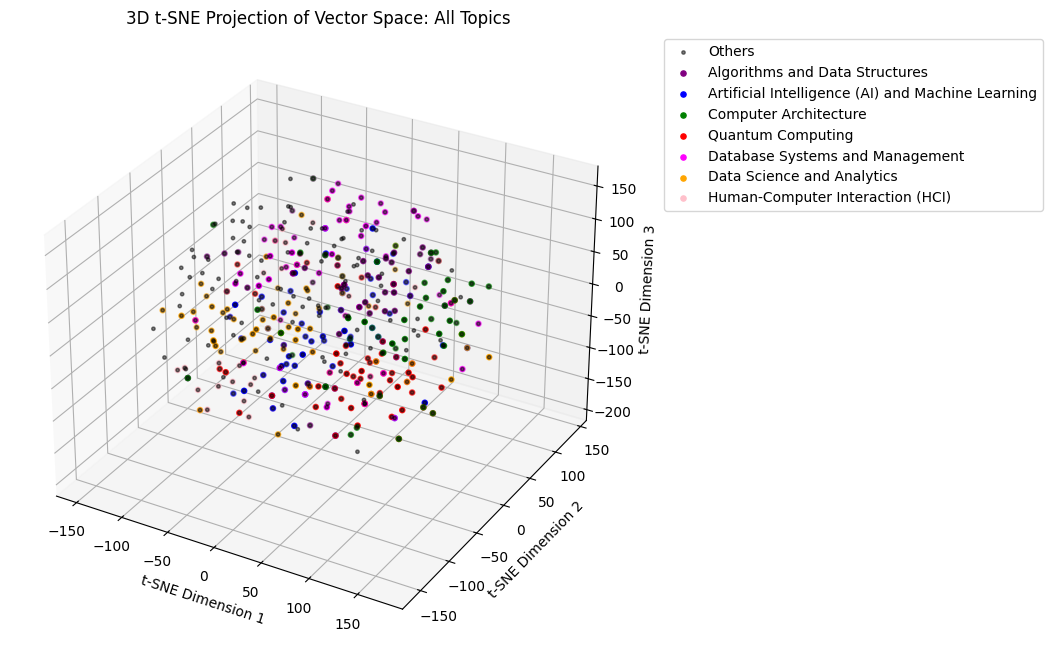

In [93]:
### 3D t-sne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

perplexity = 50  # Try values like 5, 30, or 50
learning_rate = 200  # Try values within 10 to 1000
n_iter = 1000  # Increase if necessary, default is 1000

tsne = TSNE(n_components=3, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
tsne_results = tsne.fit_transform(tsne_vectors)

plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection='3d')  # Create a 3D subplot

# Scatter plot for all vectors in 3D
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], s=6, c='black', alpha=0.5, label='Others')

colors = ['purple', 'blue', 'green', 'red', 'magenta', 'orange', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']
for topic_id in topics:
    highlight_idx = topic_highlight_idx[str(topic_id)]
    ax.scatter(tsne_results[highlight_idx, 0], tsne_results[highlight_idx, 1], tsne_results[highlight_idx, 2], s=14, label=alltopics[str(topic_id)], c=colors.pop(0))

# plt.xlim(-25, 25)
# plt.ylim(-25, 25) 
# ax.set_zlim(-25, 25)

ax.set_title(f'3D t-SNE Projection of Vector Space: All Topics')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

os.makedirs(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/combined/3D', exist_ok=True)
run = len(os.listdir(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/combined/3D')) + 1
f_metadata = open(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/combined/3D/{run}_metadata.yaml', 'w')
f_metadata.write(f'Perplexity: {perplexity}, Learning Rate: {learning_rate}, Iterations: {n_iter}\n')
f_metadata.close()
# Save the plot

plt.savefig(f'{OUTPUT_DIR}/vectorspace/{VECTOR_MODE}/combined/3D/{run}_all_topics.png')


In [ ]:
########## SINGLE GRAPH
## A list of torch tensors 
# https://distill.pub/2016/misread-tsne/
tsne_vectors = numpy.array([obj["vector"].numpy() for obj in vectors.values()])
tsne_labels = [set(obj["topics"]) for obj in vectors.values()]

# Use t-SNE to reduce dimensionality
perplexity = 30  
learning_rate = 500
n_iter = 1000

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tsne_vectors)

# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot for all vectors
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=8, c='black', alpha=0.5, label='Others')

# Highlight vectors labeled with 
target_topic = 1
target_topic_name = alltopics[str(target_topic)]
highlight_idx = [i for i, label in enumerate(tsne_labels) if target_topic in label]
plt.scatter(tsne_results[highlight_idx, 0], tsne_results[highlight_idx, 1], s=8, c='orange', label=target_topic_name)

plt.title('2D t-SNE Projection of Vector Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

